In [7]:
import numpy as np 
import pyfits
from scipy.interpolate import RegularGridInterpolator

In [23]:

currentExpCube, expcubehdu = None, None  # keeps track of the current gtexpcube2
def GetExpMap(E_min, E_max, l, b, expcube, subsamples=5, spectral_index=-2):
    """
    Returns the effective area given the energy range and angular coordinates.

    :param    E_min: Min energy in MeV
    :param    E_max: Max Energy in MeV
    :param    l: Galactic longitude.
    :param    b: Galactic latitude.
    :param    expcube: Exposure cube file over observation from Fermitools gtexpcube2.
    :param    subsamples: Number of sub-bins for integration (note that the exposure is already power-law interpolated
                so this can be relatively small)
    :param    spectral_index=-2: When combining the subbins, a spectrum must be assumed for weighting.  This is only
              reasonably important at energies < 100
    :return   Effective Exposure: value of the effective exposure in cm^2*s at the given coordinates.

    """
    # TODO: GetExpMap THIS NEEDS TO BE MORE ACCURATE.  Especially at high energies.  Need to generate many spectral bins and integrate carefully.

    # check if the expCube has already been opened.
    global currentExpCube, expcubehdu
    if expcube != currentExpCube:
        expcubehdu = pyfits.open(expcube)

    energies = np.log10(expcubehdu[1].data.field(0))
    lats = np.linspace(-90, 90, expcubehdu[0].header['NAXIS2'])
    lons = np.linspace(-180, 180, expcubehdu[0].header['NAXIS1'])
    # Need to reverse the first axis of the
    reversed_arr = np.swapaxes(np.swapaxes(expcubehdu[0].data, 0, 2)[::-1], 0, 2)

    # Build the interpolator
    rgi = RegularGridInterpolator((energies, lats, lons), reversed_arr, method='linear',
                                  bounds_error=False, fill_value=np.float32(0.))

    # convert 0-360 to -180-180
    l, b = np.array(l), np.array(b)
    if l.ndim == 0:
        if l > 180:
            l -= 360
        interpolated = 0.
    else:
        l[l > 180] -= 360.
        interpolated = np.zeros(l.shape[0])


    # average_E = 10**(0.5*(np.log10(E_min)+np.log10(E_max)))
    # Weight against the spectrum.
    E_list = np.logspace(np.log10(E_min), np.log10(E_max), subsamples)
    weights = E_list**-spectral_index

    for i, E in enumerate(E_list):
        interpolated += rgi((np.log10(E), b, l))*(weights[i]/np.sum(weights))        
    #interpolated = np.average(rgi((np.log10(E_list), b, l)), weights=weights, axis=0)

    return interpolated


In [26]:

E_bins = np.load('../output/E_bins.npy')
l_bins = np.load('../output/l_bins_0.1deg.npy')
b_bins = np.load('../output/b_bins_0.1deg.npy')
bin_centers_l = .5* (l_bins[1:]+l_bins[:-1])

bin_centers_b = .5* (b_bins[1:]+b_bins[:-1])

expmap = np.zeros( shape = (E_bins.shape[0]-1, b_bins.shape[0]-1, l_bins.shape[0]-1) )
# Fill in the exposure map 
for i_E in range(len(E_bins)-1):
    for i_b, b in enumerate(bin_centers_b):
        expmap[i_E, i_b] = GetExpMap(E_min=E_bins[i_E]*1e3, E_max=E_bins[i_E+1]*1e3,
                                     l=bin_centers_l, b=b,
                                     expcube='../fermi_output/gtexpcube2_P8R2_PSF3_CLEAN_wavelets.fits')



In [29]:
np.save('../output/exp_map_0.1deg.npy', expmap)

(20.0, -20.0)

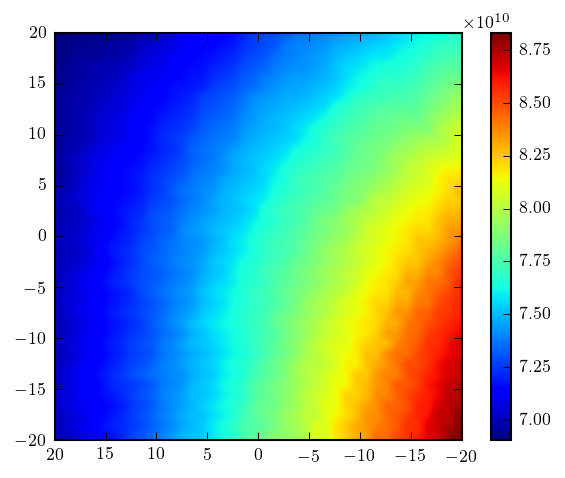

In [27]:
im = plt.imshow(expmap[1], origin='lower', extent=[min(l_bins), max(l_bins), min(b_bins), max(b_bins)])
plt.colorbar(im)
plt.xlim(max(l_bins), min(l_bins))

In [28]:
for i in range(5):
    print np.mean(expmap[i])

69423682853.3
76221032031.6
73028363717.8
69622087236.9
72943246311.8
